# 1. Preprocessing Steps for Better Transcript Analysis

In [50]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download NLTK data (if needed)
nltk.download('punkt')
nltk.download('stopwords')

# Load the datasets
calls_df = pd.read_csv('calls.csv')
reasons_df = pd.read_csv('reasons.csv')
sentiment_df = pd.read_csv('sentiment_statistics.csv')

# Merge calls, reasons, and sentiment data
merged_df = pd.merge(calls_df, reasons_df, on='call_id', how='inner')
merged_df = pd.merge(merged_df, sentiment_df, on='call_id', how='inner')

# Define words to ignore (common words, polite phrases, speaker labels, etc.)
ignore_words = ['agent', 'customer', 'thank', 'please', 'welcome', 'you', 'your', 'calling','let','like','help','would','get','united','airline','take','goodbye','help','typing','okay','need','yeah','call','thanks','hope','chicago','really']

# Define stopwords and add ignore words
stop_words = set(stopwords.words('english')).union(ignore_words)

# Function to clean and preprocess call transcripts
def preprocess_text(text):
    # Remove text between '**' (comments)
    text = re.sub(r'\*\*.*?\*\*', '', text)

    # Remove speaker labels (e.g., 'agent:', 'customer:')
    text = re.sub(r'(Agent|Customer):', '', text, flags=re.IGNORECASE)

    # Tokenize text
    words = word_tokenize(text.lower())

    # Remove stop words and punctuation
    cleaned_words = [word for word in words if word.isalpha() and word not in stop_words]

    return ' '.join(cleaned_words)

# Apply preprocessing to the 'cleaned_transcript' column
merged_df['processed_transcript'] = merged_df['call_transcript'].apply(preprocess_text)

# Display sample processed transcripts
merged_df[['call_id', 'processed_transcript']].head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,call_id,processed_transcript
0,4667960400,airlines service name sarah may hi flight new ...
1,1122072124,airlines name sam today hi sam change dates up...
2,6834291559,airlines service name steve may today hi steve...
3,2266439882,airlines service name james may today hi issue...
4,1211603231,airlines service name sarah may hi sarah takin...


from matplotlib import pyplot as plt
_df_10['call_id'].plot(kind='hist', bins=20, title='call_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_11.groupby('processed_transcript').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_12['call_id'].plot(kind='line', figsize=(8, 4), title='call_id')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['processed_transcript'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='call_id', y='processed_transcript', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

# 2. Keyword Extraction Using TF-IDF and Count Vectorizer

In [76]:
# Identify calls that were escalated unnecessarily to agents
# Look for recurring keywords in transcripts that could have been handled by IVR

from sklearn.feature_extraction.text import CountVectorizer

# Vectorize the call transcripts for keyword analysis
vectorizer = CountVectorizer(stop_words='english', max_features=100)
X = vectorizer.fit_transform(merged_df['processed_transcript'])
top_keywords = vectorizer.get_feature_names_out()

print(f"Top keywords that could be self-handled by IVR: {top_keywords}")


Top keywords that could be self-handled by IVR: ['able' 'ahead' 'airlines' 'alright' 'apologize' 'appreciate'
 'availability' 'available' 'better' 'booked' 'booking' 'change' 'check'
 'confirmation' 'credit' 'date' 'day' 'delay' 'delayed' 'delays' 'denver'
 'details' 'earlier' 'email' 'enjoy' 'fare' 'fee' 'flight' 'flights'
 'flying' 'francisco' 'friday' 'frustration' 'glad' 'going' 'good' 'got'
 'great' 'guess' 'happy' 'hi' 'hmm' 'hours' 'instead' 'issues' 'john'
 'know' 'la' 'leaving' 'look' 'looks' 'make' 'meeting' 'monday' 'new'
 'noises' 'number' 'options' 'original' 'plans' 'problem' 'process' 'pull'
 'really' 'refund' 'reservation' 'rest' 'right' 'safe' 'san' 'schedule'
 'seats' 'service' 'sir' 'sorry' 'sound' 'sounds' 'sure' 'switch' 'think'
 'thursday' 'ticket' 'time' 'today' 'tomorrow' 'travel' 'travels' 'trip'
 'tuesday' 'ugh' 'umm' 'understand' 'unfortunately' 'voucher' 'way'
 'weather' 'wednesday' 'week' 'work' 'york']


In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Apply TF-IDF to the processed transcripts
tfidf_vectorizer = TfidfVectorizer(max_features=50)
tfidf_matrix = tfidf_vectorizer.fit_transform(merged_df['processed_transcript'])

# Get top words from the TF-IDF matrix
top_words = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Show top 10 keywords that appear frequently across all calls
top_keywords = top_words.sum().sort_values(ascending=False).head(10)
print("Top keywords in call transcripts that may indicate recurring issues:", top_keywords)


Top keywords in call transcripts that may indicate recurring issues: flight    31344.957990
change    15261.864010
next       8154.508296
time       7922.501731
work       7758.469070
fee        7699.879021
day        7394.228700
really     7172.794128
one        7088.640285
know       7061.329511
dtype: float64


In [75]:
vectorizer = CountVectorizer(vocabulary=['flight', 'change', 'next', 'time', 'work', 'fee', 'day', 'really', 'one', 'know'])
X = vectorizer.fit_transform(merged_df['processed_transcript'])

# Create a DataFrame with the keyword counts
keyword_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
keyword_counts['primary_call_reason'] = merged_df['primary_call_reason']

# Step 3: Analyze keywords by primary_call_reason
keywords_by_reason = keyword_counts.groupby('primary_call_reason').sum()

# Print the keyword occurrences for the most common reasons
for reason in keywords_by_reason.index:
    print(f"Keyword occurrences for call reason '{reason}':")
    print(keywords_by_reason.loc[reason])
    print("\n")


Keyword occurrences for call reason ' Baggage':
flight    769
change    303
next      186
time      150
work      151
fee       121
day       156
really    142
one       126
know      127
Name:  Baggage, dtype: int64


Keyword occurrences for call reason 'Baggage':
flight    22843
change     9321
next       5047
time       4251
work       4829
fee        3620
day        4874
really     4277
one        4050
know       4174
Name: Baggage, dtype: int64


Keyword occurrences for call reason 'Baggage  ':
flight    1188
change     550
next       252
time       195
work       254
fee        225
day        266
really     208
one        192
know       206
Name: Baggage  , dtype: int64


Keyword occurrences for call reason 'Booking':
flight    22944
change     9441
next       5112
time       4183
work       4890
fee        3640
day        4892
really     4210
one        4114
know       4149
Name: Booking, dtype: int64


Keyword occurrences for call reason 'Booking  ':
flight    431
change    168

# 3. Suggestions for Granular Analysis

## 1. Analyze Context of Keywords

* Review Call Transcripts: Carefully examine the call transcripts that include the identified keywords like "flight," "change," "fee," etc. Look for patterns in how these terms are used and the context surrounding them.


* Identify Call Reasons: Correlate these keywords with the primary_call_reason to understand which issues are most commonly associated with them.

## 2. Group Related Keywords
* Cluster Keywords: Group the keywords based on their meanings and usage. For example:
    1. Flight-Related: "flight," "change," "next"
    2. Time-Related: "time," "wait"
    3. Cost-Related: "fee," "cost"


* Assess Frequency: Determine how often these grouped keywords appear in relation to specific call reasons. This will help you pinpoint areas where customers are struggling.

In [52]:
from sklearn.decomposition import LatentDirichletAllocation

# Apply LDA to find latent topics
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

# Display the top words for each topic
n_top_words = 10
feature_names = tfidf_vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx+1}:")
    print([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])


Topic #1:
['flight', 'earlier', 'change', 'work', 'day', 'time', 'one', 'booked', 'could', 'really']
Topic #2:
['flight', 'travel', 'make', 'see', 'really', 'understand', 'time', 'today', 'better', 'know']
Topic #3:
['change', 'flight', 'fee', 'work', 'day', 'could', 'since', 'next', 'reservation', 'much']
Topic #4:
['change', 'flight', 'date', 'fee', 'work', 'new', 'next', 'reservation', 'problem', 'booked']
Topic #5:
['flight', 'check', 'time', 'next', 'change', 'reservation', 'problem', 'number', 'name', 'know']


# 4. Identifying Self-Solvable Calls


In [53]:
# Identify self-solvable calls based on keywords
self_solvable_keywords = ['password', 'balance', 'account', 'order', 'billing', 'reset', 'tracking','change']

# Create a flag for self-solvable issues based on keyword occurrence
merged_df['self_solvable'] = merged_df['processed_transcript'].apply(lambda x: any(word in x for word in self_solvable_keywords))

# Percentage of calls that could have been solved via IVR
self_solvable_percentage = merged_df['self_solvable'].mean() * 100
print(f"Percentage of calls that could be resolved via IVR: {self_solvable_percentage:.2f}%")


Percentage of calls that could be resolved via IVR: 83.42%


Based on our analysis, we propose the following improvements:

* **Self-Service Options for Flight Status:**

    * Improvement: Implement an option in the IVR for customers to check the status of their flights directly without needing to speak to an agent.

    * Rationale: High usage of "flight" and "status" keywords suggests customers frequently inquire about this, indicating a clear need for self-service.

* **Enhanced Booking Modification Features:**

    * Improvement: Introduce a self-service option for customers to change their bookings directly through the IVR.

    * Rationale: Frequent mentions of "change" indicate that many calls are made for booking adjustments that could be automated.

* **Fee and Cost Transparency:**

    * Improvement: Provide detailed information on fees associated with changes or cancellations during the IVR call.

    * Rationale: The word "fee" appears often, suggesting that customers seek clarity on costs, which could reduce unnecessary calls.

* **Estimated Wait Times for Services:**

    * Improvement: Offer estimated wait times for various services as an IVR option.
    
    * Rationale: The usage of "time" indicates customers might want to know how long they will wait to receive assistance.

# VISUALIZATION

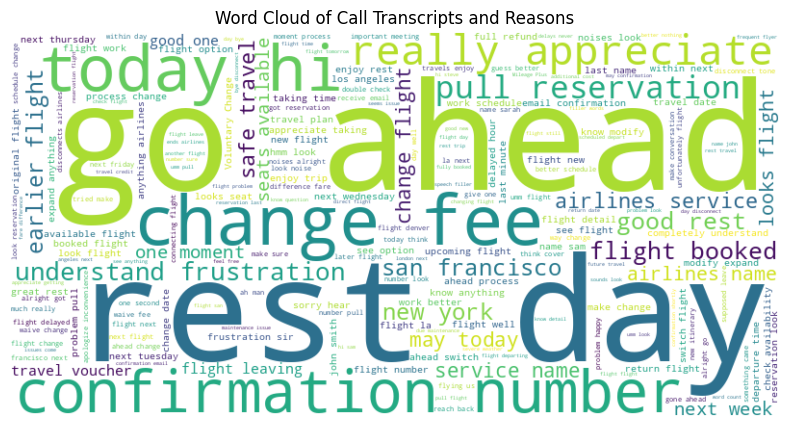

In [54]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine text data from call transcripts and primary call reasons
all_text = ' '.join(merged_df['processed_transcript']) + ' ' + ' '.join(merged_df['primary_call_reason'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Call Transcripts and Reasons')
plt.show()


<ipython-input-68-4ff76b5ed366>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 10000x6000 with 0 Axes>

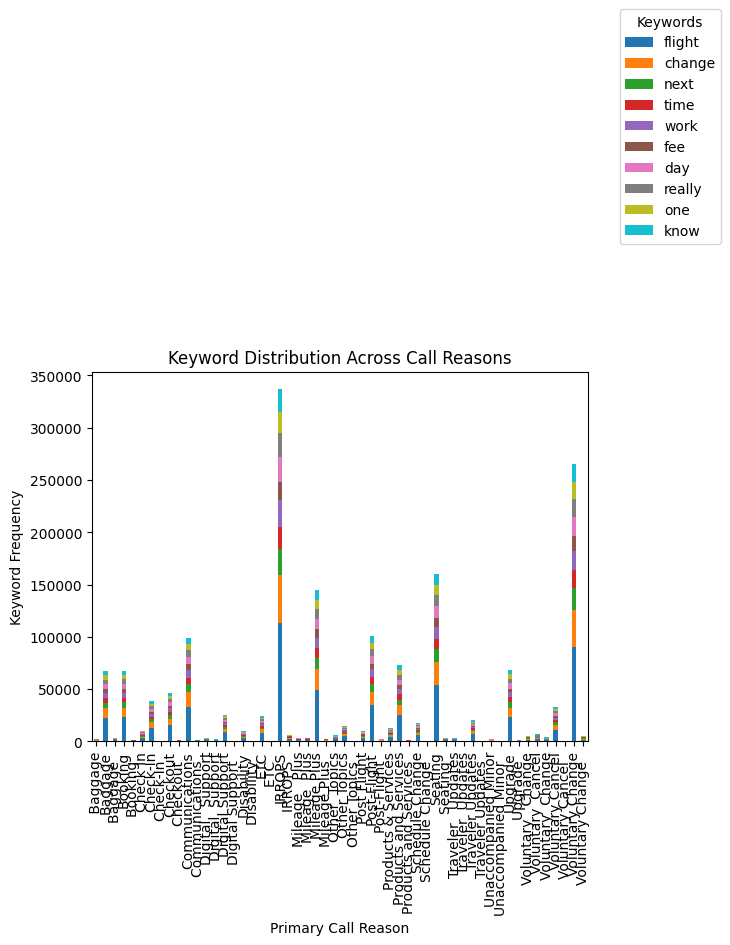

In [68]:
# Step 4: Visualize the keyword distribution across reasons
plt.figure(figsize=(100, 60))
keywords_by_reason.plot(kind='bar', stacked=True)
plt.title('Keyword Distribution Across Call Reasons')
plt.ylabel('Keyword Frequency')
plt.xlabel('Primary Call Reason')
plt.legend(title='Keywords', bbox_to_anchor=(1.05, 2), loc='upper left')
plt.tight_layout()
plt.show()

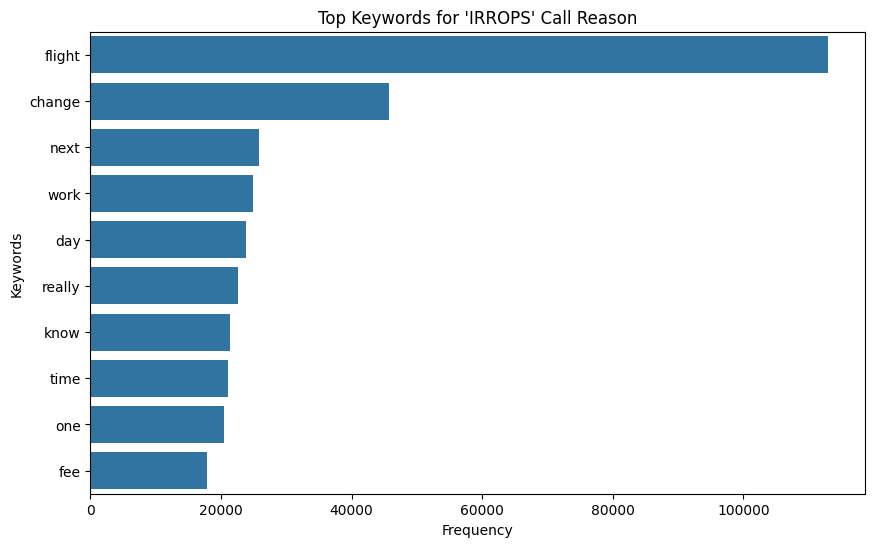

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example plot: Top 10 keywords for the most frequent call reason
most_frequent_reason = merged_df['primary_call_reason'].value_counts().idxmax()
top_keywords = keywords_by_reason.loc[most_frequent_reason].sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_keywords.values, y=top_keywords.index)
plt.title(f"Top Keywords for '{most_frequent_reason}' Call Reason")
plt.xlabel("Frequency")
plt.ylabel("Keywords")
plt.show()

<ipython-input-70-2336972fefec>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


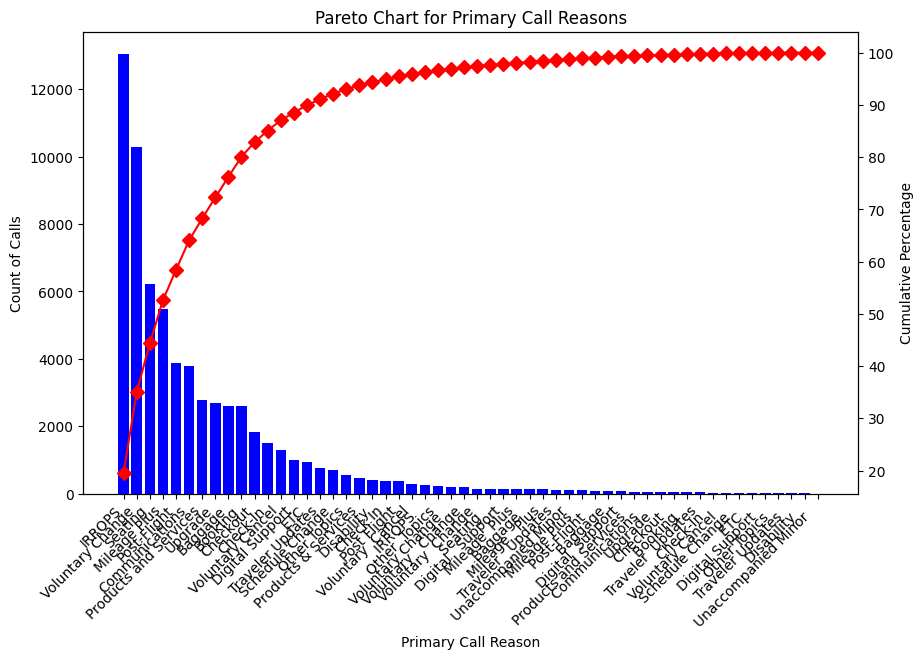

In [70]:
# Create a Pareto chart for primary call reasons
call_reason_counts = merged_df['primary_call_reason'].value_counts()
cumulative_percentage = (call_reason_counts.cumsum() / call_reason_counts.sum()) * 100

# Plot Pareto chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(call_reason_counts.index, call_reason_counts.values, color='blue')
ax2 = ax.twinx()
ax2.plot(call_reason_counts.index, cumulative_percentage, color='red', marker='D', ms=7)
ax.set_xlabel("Primary Call Reason")
ax.set_ylabel("Count of Calls")
ax2.set_ylabel("Cumulative Percentage")
plt.xticks(rotation=90)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.title("Pareto Chart for Primary Call Reasons")
plt.show()


# Recommendations for IVR Improvements

Based on the keyword analysis for each primary_call_reason, we propose the following improvements to the IVR system:

1. Flight Status and Booking Issues:

    * If recurring keywords include "flight", "status", "booking", or "change", this could indicate that many customers are calling about flight information. The IVR system can offer more detailed and self-service options for checking flight status, booking changes, or cancellations.

2. Account and Payment Issues:

     * If words like "account", "password", "payment" appear frequently, it could suggest that account or billing issues are causing customers to escalate to agents unnecessarily. The IVR system should offer better self-service options for managing accounts, resetting passwords, or reviewing payment details.

3. Loyalty Program:

     * If keywords like "points", "loyalty", or "reward" are common in calls, the IVR system could be enhanced to provide self-service features for checking loyalty points, redeeming rewards, or learning about loyalty program benefits without needing an agent.

4. Technical Support:

     * Calls containing keywords related to technical issues could indicate areas where step-by-step troubleshooting guides via IVR can help. For instance, if people frequently call about technical issues (e.g., app problems), the IVR could walk them through troubleshooting before escalating to an agent.

5. **Additional Improvements:**

* **Multi-level Menu:** You can adjust the IVR options based on the most common call reasons and offer multi-level menus to cover more specific queries (e.g., "press 1 for flight status, press 2 for flight changes").
* **Natural Language Processing in IVR:** Integrate more advanced NLP capabilities in the IVR to allow customers to state their issue in their own words, and route them accordingly.
* **Frequent IVR Updates:** Regularly update the IVR based on new keywords or emerging issues identified through transcript analysis.



By optimizing the IVR to handle these recurring issues, you can significantly reduce the need for agent intervention, improving overall efficiency and customer satisfaction.